# Captum

In [57]:
from ipdb import set_trace as breakpoint
from functools import lru_cache
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from tqdm.contrib.itertools import product
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xarray as xr
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torchvision.transforms import Compose
import pytorch_lightning as pl
from captum.attr import IntegratedGradients, Saliency, DeepLift, GuidedGradCam, NoiseTunnel, LayerGradCam
from captum.attr import visualization as viz

from arnet.modeling.learner import Learner
from arnet.dataset import ActiveRegionDataModule, ActiveRegionDataset
from arnet.transforms import get_transform
from mlflow_helper import retrieve
from captum_helper import get_heatmap, plot_heatmaps_info, add_label, add_pred, get_heatmaps_from_df, plot_heatmaps_contour, plot_heatmaps_overlay, get_fits_data_filepath, load_data_and_header, resize_heatmaps, draw_contour
from cotrain_helper import get_learner_by_query
from cv_helper import plot_time_series
from paracoord_helper import parallel_coordinates_and_hist
retrieve = lru_cache(retrieve)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
df = pd.read_csv('_selected.csv', index_col=0).reset_index(drop=True)
# from arnet/fusion.py
df.loc[:, 'flares'] = df['flares'].fillna('')
df.loc[:, 'bad_img_idx'] = df['bad_img_idx'].apply(
    lambda s: [int(x) for x in s.strip('[]').split()])

In [86]:
algorithms = ['Original',
              #'Saliency',
              'Deconvolution',
              'GuidedBackprop',
              #'IntegratedGradients', # time/memory consuming
              'DeepLift', 
              #'LayerGradCam-5',
              #'ArnetGradCam',
              'LayerGradCam-4',
              #'LayerGradCam-3', 'LayerGradCam-2',
              #'LayerLRP'
             ]
zmax = None #[10, 0.05, 0.05, 0.05, 0.0005, 0.1] # adaptive
zmin = None #[-z for z in zmax]
color_continuous_scale = [
    px.colors.sequential.gray,
    *([px.colors.diverging.RdBu_r] * (len(algorithms)-1)), #balance # white for 0.
]

In [4]:
df

,prefix,arpnum,t_start,t_end,label,flares,bad_img_idx,HEIGHT,WIDTH,SUM,SUM_SQR,FLARE_INDEX,AREA,USFLUXL,MEANGBL,R_VALUE,model_query,prob
0,HARP,5982,2015-09-26 04:48:00,2015-09-27 04:48:00,True,C1.4|C4.1|M3.6|C2.0,[],52,170,32247.787109,52526536.0,0.0,1930.764282,3.986751e+21,21.506,3.133309,cv/base/sharp/0/0/2/CNN,0.014476
1,HARP,5982,2015-09-26 06:24:00,2015-09-27 06:24:00,True,C1.4|C4.1|M3.6|C2.0|C4.5,[],52,170,34118.625000,54245920.0,0.0,2019.492432,4.217465e+21,21.997,3.327348,cv/base/sharp/0/0/2/CNN,0.046034
2,HARP,5982,2015-09-26 08:00:00,2015-09-27 08:00:00,True,C1.4|C4.1|M3.6|C2.0|C4.5,[],52,170,53700.820312,56002132.0,0.0,2131.690186,4.594860e+21,21.066,3.129978,cv/base/sharp/0/0/2/CNN,0.049314
3,HARP,5982,2015-09-26 09:36:00,2015-09-27 09:36:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,62026.578125,61246932.0,0.0,2228.038086,5.040325e+21,20.682,3.214922,cv/base/sharp/0/0/2/CNN,0.065485
4,HARP,5982,2015-09-26 11:12:00,2015-09-27 11:12:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,73711.007812,66570756.0,0.0,2361.739990,5.486741e+21,20.457,3.296535,cv/base/sharp/0/0/2/CNN,0.129238
5,HARP,5982,2015-09-26 12:48:00,2015-09-27 12:48:00,True,C1.4|C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,89638.734375,77535568.0,0.0,2447.385254,6.015492e+21,20.129,3.387308,cv/base/sharp/0/0/2/CNN,0.250729
6,HARP,5982,2015-09-26 14:24:00,2015-09-27 14:24:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,103876.687500,86481936.0,1.4,2596.726074,6.554662e+21,19.801,3.389807,cv/base/sharp/0/0/2/CNN,0.493470
7,HARP,5982,2015-09-26 16:00:00,2015-09-27 16:00:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,115319.476562,95509664.0,1.4,2728.608643,7.029264e+21,19.247,3.450600,cv/base/sharp/0/0/2/CNN,0.876052
8,HARP,5982,2015-09-26 17:36:00,2015-09-27 17:36:00,True,C4.1|M3.6|C2.0|C4.5|C3.7,[],52,170,126386.210938,103342448.0,1.4,2872.902344,7.475611e+21,18.661,3.463092,cv/base/sharp/0/0/2/CNN,0.960878


## Single frame

In [259]:
heatmaps = get_heatmaps_from_df(df, algorithms, baseline_type='zero', target_type='neg')

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'CNN'])


  0%|          | 0/3 [00:00<?, ?it/s]

/home/zeyusun/work/flare-prediction-smarp/notebooks/captum_helper.py:34: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



In [226]:
heatmaps = resize_heatmaps(heatmaps, df)

In [55]:
## Inspect to tune hyperparameters
# heatmaps['IntegratedGradients'][0].shape
# heatmaps['IntegratedGradients'][0].sum()
# plt.hist(heatmaps['IntegratedGradients'][0].ravel())
# plt.hist(heatmaps['LayerGradCam'][1].ravel())

## Test for px.imshow to make sure the original functionality works
# px.imshow(heatmaps['LayerGradCam'][0].squeeze(), color_continuous_scale=px.colors.diverging.RdBu_r)

In [ ]:
# m.shape = (C, T, H, W) is a single instance
g = lambda m: m[0, 0, :, :] #.transpose(1,2,0)
for i in df.index:
    display(df.iloc[[i]])

    imgs = np.array([g(heatmaps[a][i]) for a in heatmaps])
    algorithms = list(heatmaps.keys())
    fig = plot_heatmaps_info(imgs, algorithms, df.iloc[i],
                             zmin, zmax, color_continuous_scale,
                             animation_frame=None)
    kwargs = {f'{xy}axis{i}': {'showticklabels': False}
              for i in ['', *range(2, len(algorithms)+1)]
              for xy in ['x', 'y']}
    height = 250
    fig.update_layout(
        margin={'l': 0, 'r': 0, 't': 0, 'b': 0},
        height=height,
        width=height * len(algorithms) * 1.2, # 5 columns
        #width=1800, # 8 columns
        **kwargs,
    )
    fig.show(config={'modeBarButtonsToAdd':['drawopenpath', 'eraseshape']})
    filename = f'attribution_zero/{i}'
    #fig.write_image(filename + '.png')
    #fig.write_image(filename + '.pdf')

## Movie with prediction with baseline first frame

In [7]:
from arnet.transforms import calc_stats
hist = np.load('/home/zeyusun/work/flare-prediction-smarp/datasets/sharp_hist.npy', allow_pickle=True).item()
#func = get_transform('ValueTransform', cfg) if 'ValueTransform' in cfg.DATA.TRANSFORMS else None             
#mean, std = 
calc_stats(hist['hist'], hist['bins'], func=None)

(-0.02334314373614411, 93.78056679862786)

MDI/HMI maximum 2000 Gs. Standard deviation ~100. So the transformed input has maximum magnitutde 20.

In [87]:
heatmaps = get_heatmaps_from_df(df, algorithms, baseline_type='first')

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'CNN'])


  0%|          | 0/5 [00:00<?, ?it/s]

/home/zeyusun/work/flare-prediction-smarp/notebooks/captum_helper.py:45: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning:

Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning:

Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished



In [17]:
df.to_csv('_temp.csv')

In [88]:
heatmaps = resize_heatmaps(heatmaps, df)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/skimage/transform/_warps.py:176: UserWarning:

Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.



In [ ]:
# when df is a continuous time series for an active region
# concatenate all heatmaps along the time dimension
imgs = np.array([np.concatenate(heatmaps[a], axis=1)[0] for a in heatmaps])
algorithms = list(heatmaps.keys())
fig = plot_heatmaps_info(imgs, algorithms, df,
                         zmin, zmax, color_continuous_scale,
                         animation_frame=1, facet_col_wrap=2)
fig.show(config={'modeBarButtonsToAdd':['drawopenpath', 'eraseshape']})
fig.write_html('captum_movie_first.html')

In [ ]:
from copy import deepcopy
_heatmaps = deepcopy(heatmaps)

In [ ]:
heatmaps = deepcopy(_heatmaps)

In [282]:
# hotfix
heatmaps = {k: v for k, v in heatmaps.items() if k in ['Original', 'IntegratedGradients']}

In [ ]:
from captum_helper import draw_attribution
draw_attribution(df, algorithms = algorithms)

In [ ]:
# m.shape = (C, T, H, W) is a single instance
g = lambda m: m[0, 0, :, :] #.transpose(1,2,0)

#for i in df.index:
i = df.index[-1]

display(df.iloc[[i]])

imgs = np.array([g(heatmaps[a][i]) for a in heatmaps])
algorithms = list(heatmaps.keys())
fig = plot_heatmaps_info(imgs, algorithms, df.iloc[i],
                         zmin, zmax, color_continuous_scale,
                         #facet_col_wrap=3,
                         animation_frame=None)
kwargs = {f'{xy}axis{i}': {'showticklabels': False}
          for i in ['', *range(2, len(algorithms)+1)]
          for xy in ['x', 'y']}
height = 200
fig.update_layout(
    margin={'l': 0, 'r': 0, 't': 20, 'b': 0}, # title seems to be out of margin
    height=width,
    width=height * len(algorithms) * 0.95 * (imgs.shape[2] / imgs.shape[1]), # 5 columns
    #width=1800, # 8 columns
    **kwargs,
)
fig.show(config={'modeBarButtonsToAdd':['drawopenpath', 'eraseshape']})
filename = f'attribution_first/{i}'
#fig.write_image(filename + '.png')
#fig.write_image(filename + '.pdf')
fig.write_image('contours/5982/2015-09-27 04:48:00/a15.pdf')

## Inspect Grad-CAM

In [ ]:
from scipy.ndimage import zoom

In [ ]:
_algorithms = ['LayerGradCam']
heatmaps = get_heatmaps_from_df(df, _algorithms, baseline_type='zero')

In [61]:
def _save(inputs, layer_evals, summed_grads):
    """
    Usage:
    ```python
    from arnet.utils.debug import _save
    _save(inputs, layer_evals, summed_grads)
    ```

    Args: All inputs are tuples of len 1.
    ```
    ipdb>  layer_evals[0].shape
    torch.Size([9, 64, 1, 8, 8])
    ipdb>  inputs[0].shape
    torch.Size([9, 1, 1, 128, 128])
    ipdb>  summed_grads[0].shape
    torch.Size([9, 64, 1, 1, 1])
    ```
    """
    import numpy as np
    tensors = [inputs[0], layer_evals[0], summed_grads[0]]
    names = ['_inputs', '_layer_evals', '_summed_grads']
    for t, n in zip(tensors, names):
        np.save(n, t.detach().cpu().numpy())

def _load():
    import numpy as np
    i = np.load('_inputs.npy')
    l = np.load('_layer_evals.npy')
    s = np.load('_summed_grads.npy')
    return i, l, s

In [18]:
i, l, s = _load()

In [63]:
i.shape

(9, 1, 1, 128, 128)

In [20]:
l.shape

(9, 64, 1, 8, 8)

In [39]:
s.shape

(9, 64, 1, 1, 1)

In [ ]:
px.imshow(i[:,0,0],
          animation_frame=0,
          color_continuous_scale='RdBu_r', color_continuous_midpoint=0,
         )

In [66]:
gradcam = np.sum(l * s, axis=1, keepdims=True)[:, 0, 0]
gradcam_reshaped = np.array([zoom(g, [128/8, 128/8]) for g in gradcam])
gradcam.shape

(9, 8, 8)

In [ ]:
px.imshow(#gradcam_reshaped,
          gradcam,
          animation_frame=0,
          color_continuous_scale='RdBu_r', color_continuous_midpoint=0,
         )

In [ ]:
px.imshow(s.reshape(9,8,8), animation_frame=0,
          color_continuous_scale='RdBu_r', color_continuous_midpoint=0,
         )

In [ ]:
fig = px.imshow(#l[:,:,0],
                (l * s)[:,:,0],
                animation_frame=0, facet_col=1, facet_col_wrap=8, facet_col_spacing=0,
                color_continuous_scale='RdBu_r', color_continuous_midpoint=0,
)
fig.update_layout(
    height=1500
)

## Track

In [27]:
from glob import glob

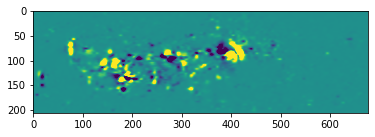

In [22]:
from scipy.ndimage import gaussian_filter
plt.imshow(gaussian_filter(heatmaps['IntegratedGradients'][-1][0,0], sigma=1), vmin=-0.01, vmax=0.01)

dict_values(['cv', 'base', 'sharp', '0', '0', '2', 'CNN'])


  0%|          | 0/2 [00:00<?, ?it/s]

/home/zeyusun/work/flare-prediction-smarp/notebooks/captum_helper.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target) # target may be an int, e.g., 1
/home/zeyusun/work/flare-prediction-smarp/notebooks/captum_helper.py:413: UserWarning: No contour levels were found within the data range.
  ax.contour(mask_smoothed,
/home/zeyusun/work/flare-prediction-smarp/notebooks/captum_helper.py:435: UserWarning: No contour levels were found within the data range.
  ax.contour(mask_smoothed,


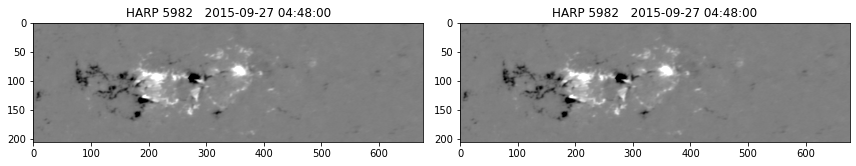

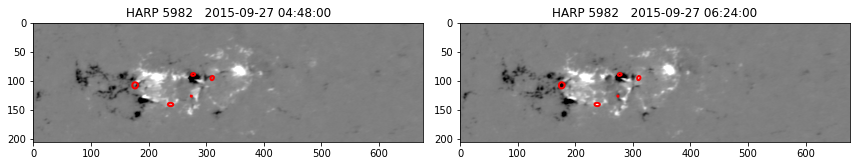

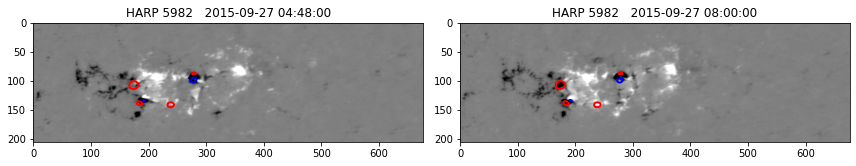

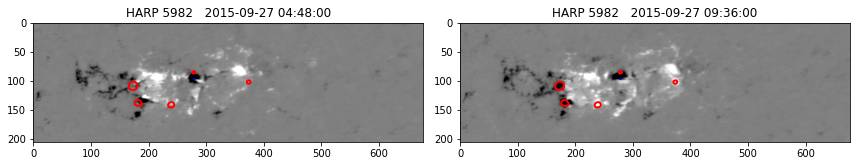

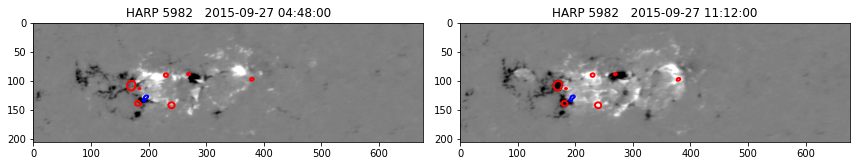

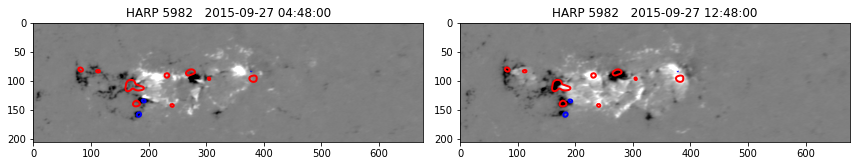

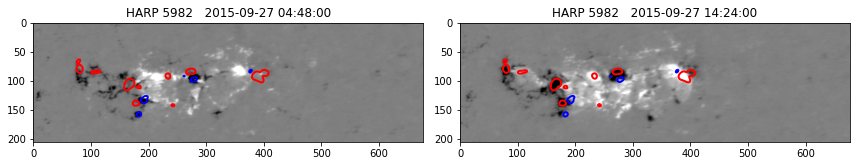

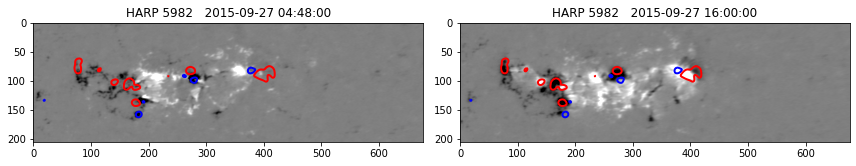

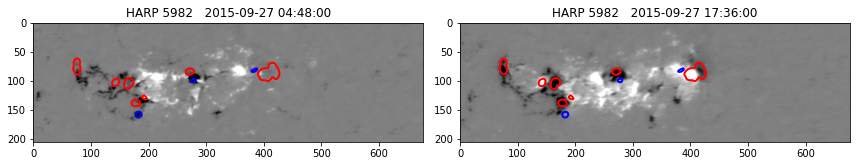

In [36]:
draw_contour(df)

In [66]:
df.columns

Index(['prefix', 'arpnum', 't_start', 't_end', 'label', 'flares',
       'bad_img_idx', 'HEIGHT', 'WIDTH', 'SUM', 'SUM_SQR', 'FLARE_INDEX',
       'AREA', 'USFLUXL', 'MEANGBL', 'R_VALUE', 'model_query', 'prob'],
      dtype='object')

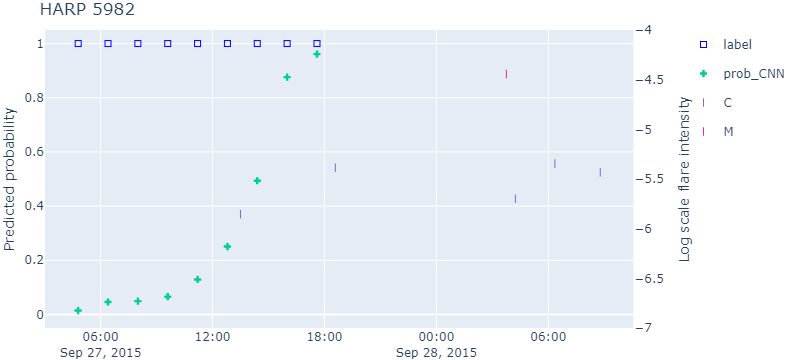

In [84]:
## Hot fix: to be consistent with captum
val_split = df['model_query'].iloc[0].split('/')[-3]
df = df.rename(columns={'prob': f'prob_CNN_{val_split}'})
##
## No such columns
#fig = plot_time_series(df, prob_columns=[f'prob_CNN_{val_split}' for val_split in range(5)])
arpnum, t_end = df[['arpnum', 't_end']].iloc[0]
fig.update_layout(
        height=200,
        width=900,
        margin=go.layout.Margin(
            l=0, #left margin
            r=0, #right margin
            b=0, #bottom margin
            t=30  #top margin
        )
    )
fig.data[1].name = 'prob_CNN'
# fig.write_image(f'contours/{arpnum}/{t_end}/time_series.pdf')
fig

In [46]:
# plotly works without animation

vmax = np.percentile(np.absolute(heatmaps['IntegratedGradients']), 99) # perceptive max: 0.0115
vmin = -vmax
levelmax = vmax * 0.8
levelmin = -levelmax
frames = []
for t in range(len(heatmaps['Original'])):
    image = heatmaps['Original'][t][0,0]
    mask = heatmaps['IntegratedGradients'][t][0,0]
    mask_smoothed = gaussian_filter(mask, sigma=1)

    fig = px.imshow(image, color_continuous_scale='gray')
    fig.add_trace(go.Contour(z=mask_smoothed,
                             contours_coloring='lines',
                             colorscale='RdBu_r',
                             contours={'start': levelmin, 'end': levelmax, 'size': levelmax-levelmin},
                             #ncontours=4, # Has an effect only if `autocontour` is "True" or if `contours.size` is missing.
                             #line_smoothing=0.85,
                             line_width=2,
                            ))
    frames.append(go.Frame(data=fig.data, layout=fig.layout))

In [ ]:
# plotly animation not working properly

import plotly.graph_objects as go

fig = go.Figure(
    data=frames[0].data,
    layout=frames[0].layout,
    frames=frames,
)
# fig.update_layout({
#     'updatemenus': [
#         {
#             'type': 'buttons',
#             'buttons': [
#                 {
#                     'label': 'Play',
#                     'method': 'animate',
#                     'args': None
#                 }
#             ]
#         }
#     ]
# })

def frame_args(duration):
    return {
        "frame": {"duration": duration, "redraw": True},
        "mode": "immediate",
        "fromcurrent": True,
        "transition": {"duration": duration, "easing": "linear"},
    }

updatemenus = [
    {
        "type": "buttons",
        "direction": "left",
        "pad": {"r": 10, "t": 70},
        "x": 0.1,
        "y": 0,
        "buttons": [
            {
                "label": "&#9654;", # play symbol
                "method": "animate",
                "args": [None, frame_args(100)],
            },
            {
                "label": "&#9724;", # stop symbol
                "method": "animate",
                "args": [[None], frame_args(0)], # None should be inside []!
            }
        ]
    }
]
sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "label": "Frame "+str(k),
                "method": "animate",
                "args": [[f.name], frame_args(0)]
            }
            for k, f in enumerate(frames)
        ]
        #"active": 10,
        #"currentvalue": {"prefix": "Frequency: "},
    }
]
fig.update_layout({
    "updatemenus": updatemenus,
    "sliders": sliders
})

# fig.update_layout(updatemenus=[dict(
#             type="buttons",
#             buttons=[dict(label="Play",
#                           method="animate",
#                           args=[None])])])
fig.show()

## Overlap

In [ ]:
heatmaps_resized 
figs = plot_heatmaps_overlay(heatmaps)

In [144]:
from pathlib import Path
folder = Path('movies/overlay_all')
folder.mkdir(exist_ok=True)
for t, fig in enumerate(figs):
    # fig.show() # it will show anyway
    fig.savefig(folder / f'{t}.png', dpi=300)

In [145]:
import os, imageio
filenames = [folder / f'{i}.png' for i in range(9)]
images = list(map(lambda filename: imageio.imread(filename), filenames))
imageio.mimsave(os.path.join(folder / 'movie.gif'), images, duration = 0.5) # modify duration as needed

## Prepare

In [57]:
experiment_name = 'leaderboard3'
run_name = 'val_tss'
runs = retrieve(experiment_name, run_name)

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
245 2021-08-23 09:22:37.321000+00:00             val_tss


In [58]:
dataset_name = 'sharp'
estimator_name = 'CNN'
seed = 0

selected = runs.loc[
    (runs['tags.dataset_name'] == dataset_name) &
    (runs['params.DATA.SEED'] == str(seed)) &
    (runs['tags.estimator_name'] == estimator_name)
]
if len(selected) > 1:
    print('WARNING: more than 1 runs')

In [59]:
ckpt_path = selected['tags.checkpoint'].iloc[0]
learner = Learner.load_from_checkpoint(ckpt_path)
model = learner.model
model.eval()

kwargs = learner.cfg.TRAINER.todict()
# Saved under notebooks/mlruns and notebooks/lightning_logs
trainer = pl.Trainer(**kwargs)

dm = ActiveRegionDataModule(learner.cfg)
dl = dm.val_dataloader()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


AttributeError: VAL_SPLIT